In [3]:
mpg<-read.table("auto-mpg.txt",col.names = c("mpg","cylinders","displacement","horsepower","weight","acceleration","year","origin","name"),colClasses = c("numeric","integer","numeric","numeric","numeric","numeric","integer","factor","character"),na.strings = "?")
str(mpg)
summary(mpg)
mpg[c(1,21,32),]

'data.frame':	398 obs. of  9 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : int  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : num  130 165 150 150 140 198 220 215 225 190 ...
 $ weight      : num  3504 3693 3436 3433 3449 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ year        : int  70 70 70 70 70 70 70 70 70 70 ...
 $ origin      : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ name        : chr  "chevrolet chevelle malibu" "buick skylark 320" "plymouth satellite" "amc rebel sst" ...


      mpg          cylinders      displacement     horsepower        weight    
 Min.   : 9.00   Min.   :3.000   Min.   : 68.0   Min.   : 46.0   Min.   :1613  
 1st Qu.:17.50   1st Qu.:4.000   1st Qu.:104.2   1st Qu.: 75.0   1st Qu.:2224  
 Median :23.00   Median :4.000   Median :148.5   Median : 93.5   Median :2804  
 Mean   :23.51   Mean   :5.455   Mean   :193.4   Mean   :104.5   Mean   :2970  
 3rd Qu.:29.00   3rd Qu.:8.000   3rd Qu.:262.0   3rd Qu.:126.0   3rd Qu.:3608  
 Max.   :46.60   Max.   :8.000   Max.   :455.0   Max.   :230.0   Max.   :5140  
                                                 NA's   :6                     
  acceleration        year       origin      name          
 Min.   : 8.00   Min.   :70.00   1:249   Length:398        
 1st Qu.:13.82   1st Qu.:73.00   2: 70   Class :character  
 Median :15.50   Median :76.00   3: 79   Mode  :character  
 Mean   :15.57   Mean   :76.01                             
 3rd Qu.:17.18   3rd Qu.:79.00                             


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<chr>
1,18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
21,25,4,110,87,2672,17.5,70,2,peugeot 504
32,25,4,113,95,2228,14.0,71,3,toyota corona


There are 6 obs with `horsepower` missing. Since this is a small number comparing to $N=398$, we decide to omit the missing data.

In [78]:
mpg<-na.omit(mpg)

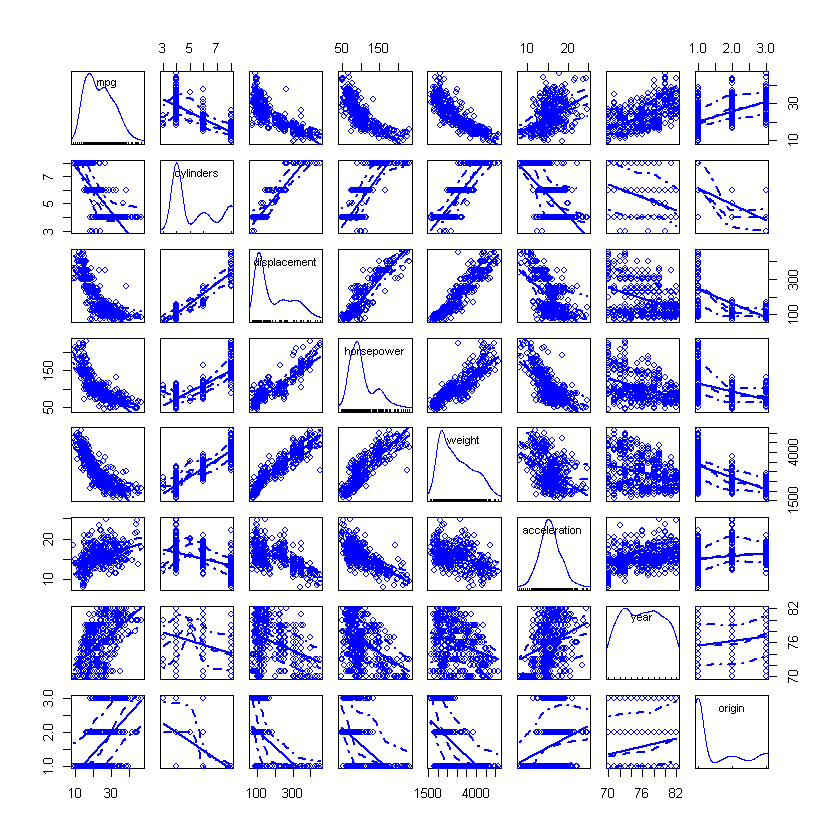

In [3]:
car::scatterplotMatrix(mpg[,-9])

We first notice that the relationship between the response `mpg` and many predictors are somewhat curved (nonlinear). This suggests transformation of variables may be necessary.

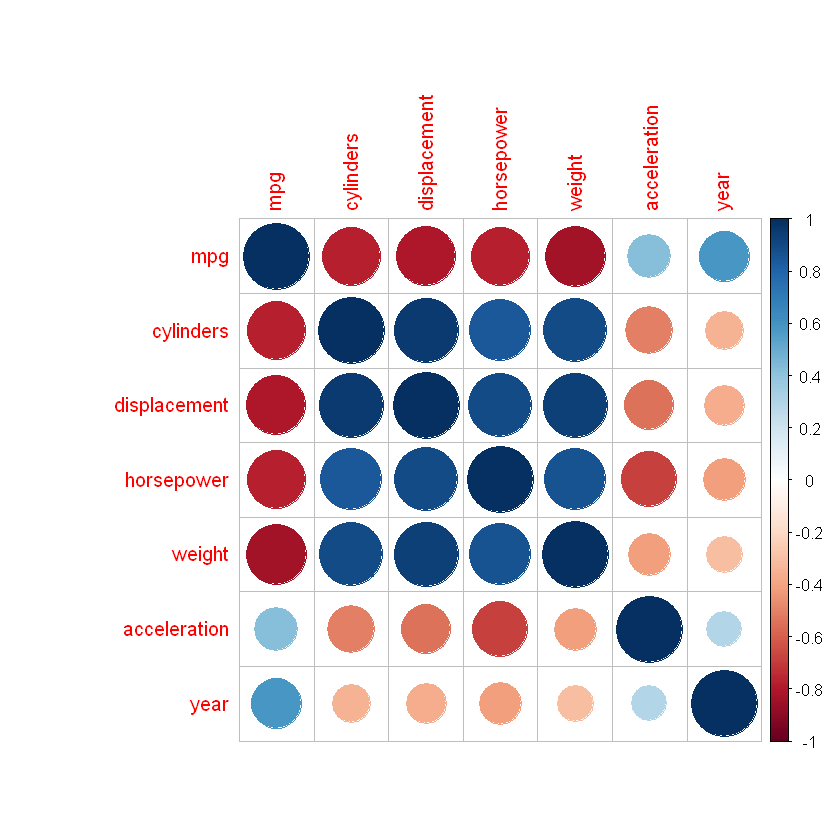

In [4]:
corrplot::corrplot(cor(mpg[,-c(8,9)]))

There are also strong correlations among the predictors, especially `cylinders`, `displacement`, `horsepower`, and `weight`. We further check the **Variance Inflation Factor**.

In [4]:
car::vif(lm(mpg~cylinders+displacement+horsepower+weight+acceleration+year,data=mpg))

cylinders displacement   horsepower       weight acceleration         year 
   10.633049    19.641683     9.398043    10.731681     2.625581     1.244829

Many of the predictors have a VIF greater than 10. For example, `displacement` can be predicted by other variables to a large extent. It is therefore necessary to do variable selection.

# Variable Transformation

We first choose the transformation of predictors.This is meant to transform the predictors into **Multinormality**.

In [6]:
summary(car::powerTransform(mpg[,3:6]))

bcPower Transformations to Multinormality 
             Est Power Rounded Pwr Wald Lwr Bnd Wald Upr Bnd
displacement   -0.0509           0      -0.2082       0.1065
horsepower     -0.1249           0      -0.2693       0.0194
weight         -0.0870           0      -0.2948       0.1208
acceleration    0.3061           0      -0.0255       0.6376

Likelihood ratio test that transformation parameters are equal to 0
 (all log transformations)
                                 LRT df    pval
LR test, lambda = (0 0 0 0) 4.872911  4 0.30059

Likelihood ratio test that no transformations are needed
                                 LRT df       pval
LR test, lambda = (1 1 1 1) 390.0777  4 < 2.22e-16

Since none of the predictors range over many orders of magnitude, we chose not to transform the predictors to maintain interpretability. However, from the scatter plot matrix, we see that there seems to be a nonlinear relationship between the response `mpg` and many of the predictors. We then use the Box-Cox transformation and try to find the $\lambda$ that minimizes the $RSS(\lambda)$ (Residual Sum of Squares). This is realized by the `MASS::boxcox()` function.

lambda,RSS
<dbl>,<dbl>
-0.37207,2339.654
-1.00000,2590.510
0.00000,2426.553
1.00000,3451.246


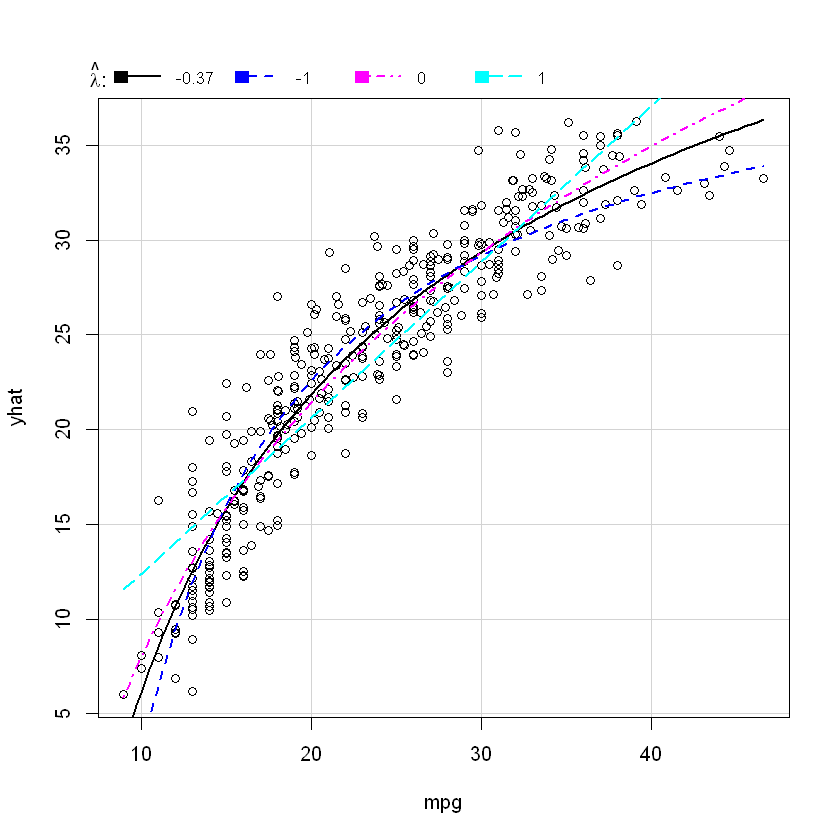

In [7]:
car::inverseResponsePlot(lm(mpg~.,data=mpg[,-9]))

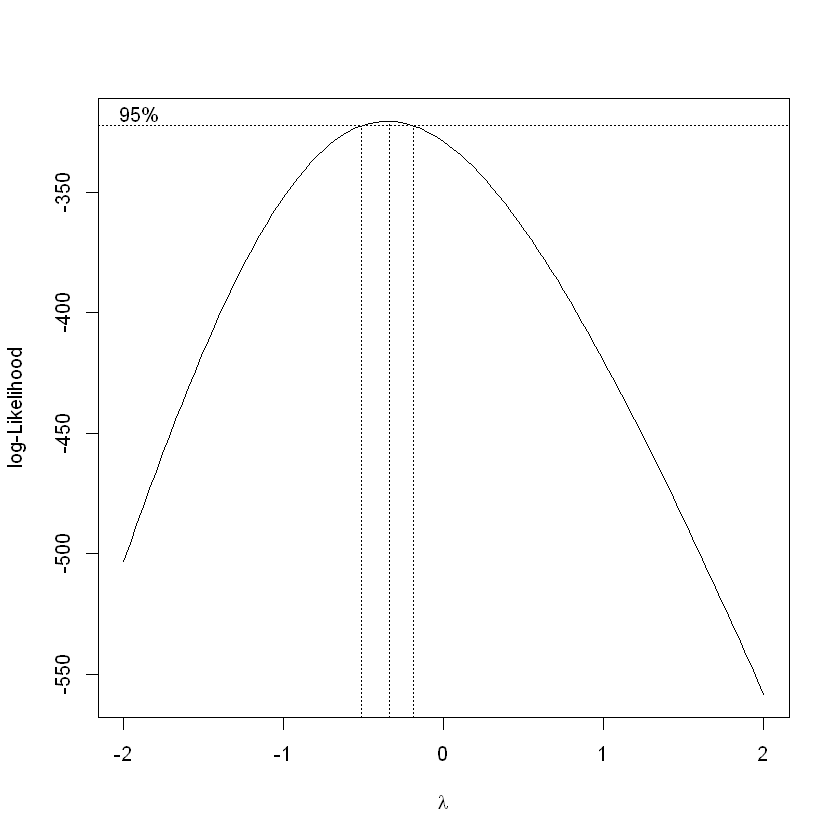

In [8]:
MASS::boxcox(lm(mpg~.,data=mpg[,-9]))

The estimated $\hat \lambda$ is -0.37. It is plausible to consider $\lambda=0$, $\lambda=-0.5$, or $\lambda=-1$. Nonetheless, we preferred to use the transformation given by $\lambda=-1$, namely $1/Y$, because it gives a very natural interpretation. Other than the US who uses $\textbf {mpg}$, most areas use the unit $\textbf {L/100km}$ for fuel consumption, which is just proportional to the inverse of its value in mpg.

In [27]:
mpg$lp100km<-100/mpg$mpg*0.621371192*3.78541178
#car::inverseResponsePlot(lm(lp100km~., data=mpg[,-c(1,9)]))

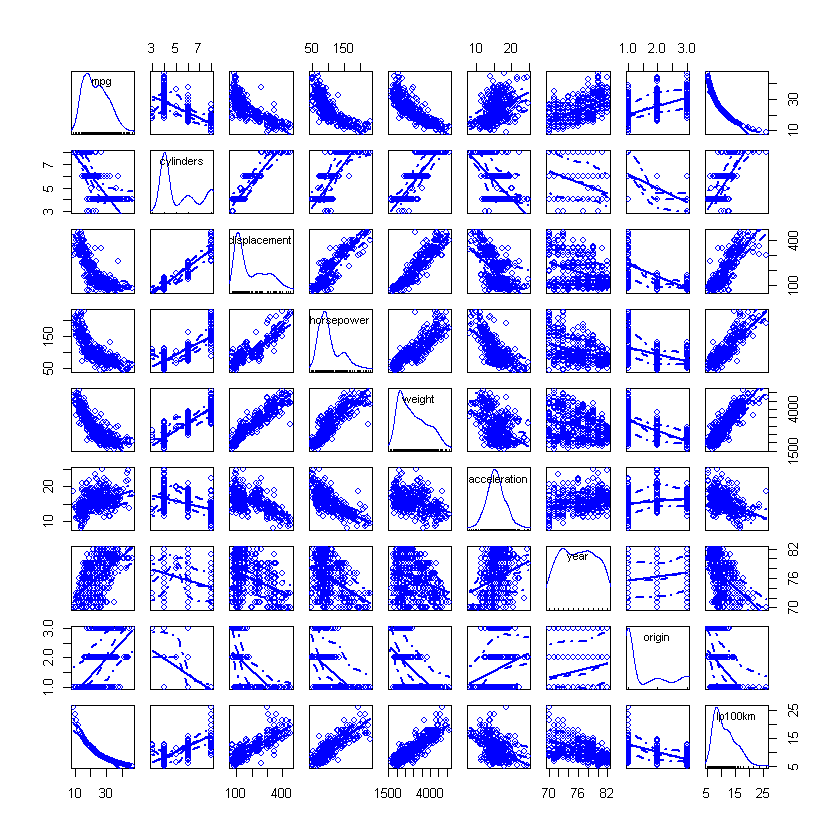

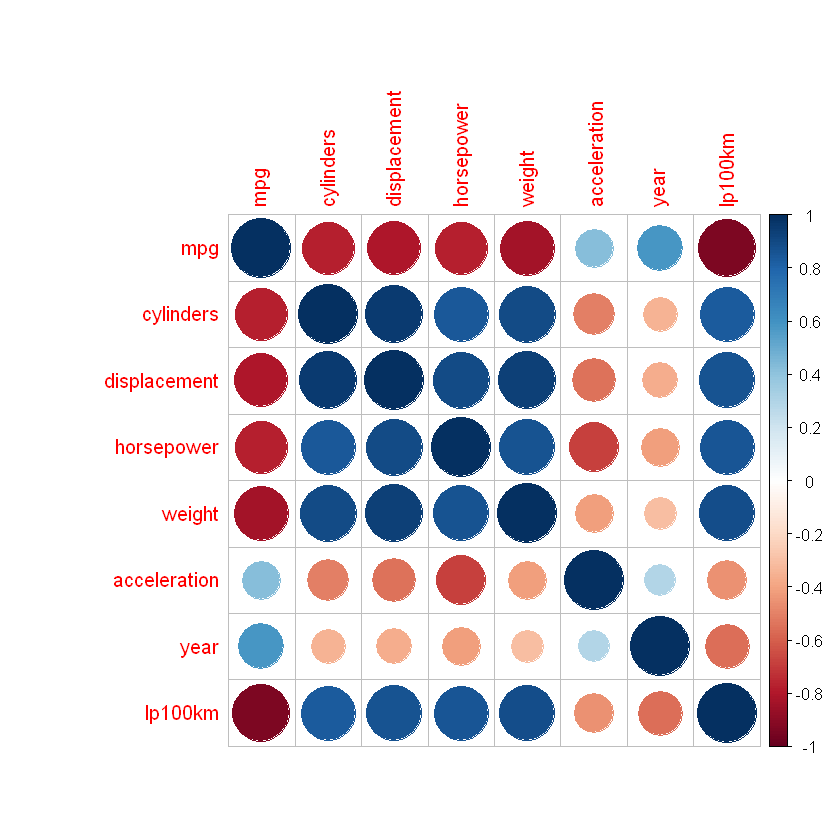

In [10]:
car::scatterplotMatrix(mpg[,-9])
corrplot::corrplot(cor(mpg[,-c(8,9)]))

We hereafter choose `lp100km` as the response variable instead of `mpg`.

In [124]:
# hist(mpg$lp100km,20)
# hist(log(mpg$lp100km),20)
# hist(sqrt(mpg$lp100km),20)

# Variable Selection via Best Subset Regression

In [51]:
lm.subset<-leaps::regsubsets(lp100km~.,data=mpg[,-c(1,9)])
#lm.subset<-leaps::regsubsets(lp100km~.,data=mpg[,c(2:5,10)])
print(summary.subset<-summary(lm.subset))

Subset selection object
Call: regsubsets.formula(lp100km ~ ., data = mpg[, -c(1, 9)])
8 Variables  (and intercept)
             Forced in Forced out
cylinders        FALSE      FALSE
displacement     FALSE      FALSE
horsepower       FALSE      FALSE
weight           FALSE      FALSE
acceleration     FALSE      FALSE
year             FALSE      FALSE
origin2          FALSE      FALSE
origin3          FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: exhaustive
         cylinders displacement horsepower weight acceleration year origin2
1  ( 1 ) " "       " "          " "        "*"    " "          " "  " "    
2  ( 1 ) " "       " "          " "        "*"    " "          "*"  " "    
3  ( 1 ) " "       " "          "*"        "*"    " "          "*"  " "    
4  ( 1 ) " "       " "          "*"        "*"    " "          "*"  "*"    
5  ( 1 ) " "       " "          "*"        "*"    "*"          "*"  "*"    
6  ( 1 ) "*"       " "          "*"        "*"    "*"       

In [88]:
X<-as.matrix(cbind(mpg[,2:7],as.numeric(mpg$origin==2),as.numeric(mpg$origin==3)))
subset.list<-list(4,c(4,6),c(3,4,6),c(3,4,6,7),c(3,4,5,6,7),c(1,3,4,5,6,7),c(1,2,3,4,6,7,8),1:8)

5-fold CV

In [100]:
CV.kFolds<-function(subset,k){
    Y<-mpg$lp100km
    set.seed(5)
    cvSplits<-caret::createFolds(mpg$lp100km,k=k)
    e<-rep(0,nrow(mpg))
    for (i in 1:k){
        beta.i<-as.vector(lm(Y[-cvSplits[[i]]]~X[-cvSplits[[i]],subset])$coef)
        #print(X[-cvSplits[[i]],subset])
        #print(beta.i)
        e[cvSplits[[i]]]<-Y[cvSplits[[i]]]-as.vector(cbind(rep(1,length(cvSplits[[i]])),X[cvSplits[[i]],subset])%*%beta.i)
        #print(e)
    }
    
    mean(e^2)
}

CV.kFolds<-Vectorize(CV.kFolds)
CV.5folds<-CV.kFolds(subset.list,5)

In [101]:
#data.frame(adjr2=summary.subset$adjr2,cp=summary.subset$cp, bic=summary.subset$bic)
display=cbind(as.data.frame(summary.subset$outmat),round(summary.subset$rsq,4),round(summary.subset$adjr2,4),
              round(summary.subset$cp,4), round(summary.subset$bic,4),round(CV.5folds,4))
colnames(display)[9:13]=c("R^2","adj R^2","Cp","BIC","5-fold CV")
display

,cylinders,displacement,horsepower,weight,acceleration,year,origin2,origin3,R^2,adj R^2,Cp,BIC,5-fold CV
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1 ( 1 ),,,,*,,,,,0.7833,0.7828,345.1945,-587.5637,3.3533
2 ( 1 ),,,,*,,*,,,0.8729,0.8723,44.0156,-790.7595,1.9542
3 ( 1 ),,,*,*,,*,,,0.8809,0.8800,18.9399,-810.2816,1.8631
4 ( 1 ),,,*,*,,*,*,,0.8823,0.8811,16.1213,-809.0264,1.8664
5 ( 1 ),,,*,*,*,*,*,,0.8835,0.8820,14.1196,-807.0152,1.8726
6 ( 1 ),*,,*,*,*,*,*,,0.8844,0.8826,13.1881,-803.9706,1.8634
7 ( 1 ),*,*,*,*,,*,*,*,0.8856,0.8835,11.2046,-802.0115,1.8897
8 ( 1 ),*,*,*,*,*,*,*,*,0.8868,0.8845,9.0000,-800.3202,1.8776


Based on BIC and 5-fold CV, we chose the model with 3 predictors: `horsepower`, `weight`, and `year`.

In [102]:
summary(lm.chosen<-lm(lp100km~horsepower+weight+year,data=mpg))


Call:
lm(formula = lp100km ~ horsepower + weight + year, data = mpg)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6445 -0.7781 -0.0415  0.6283  6.2605 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 23.4559036  1.6527787  14.192  < 2e-16 ***
horsepower   0.0190489  0.0037306   5.106 5.17e-07 ***
weight       0.0029275  0.0001616  18.113  < 2e-16 ***
year        -0.3015859  0.0205997 -14.640  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.356 on 388 degrees of freedom
Multiple R-squared:  0.8809,	Adjusted R-squared:   0.88 
F-statistic: 956.8 on 3 and 388 DF,  p-value: < 2.2e-16


All the 3 predictors have significant effects. However, we should notice that variable selection overstates significance.

# Regression Diagnostic Based on the Chosen Model

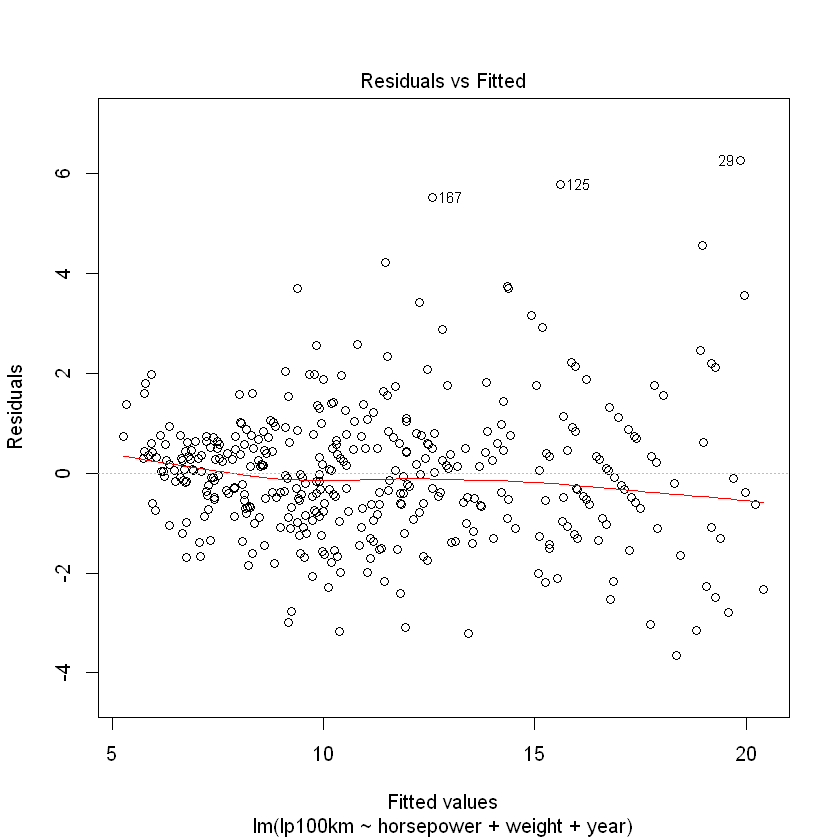

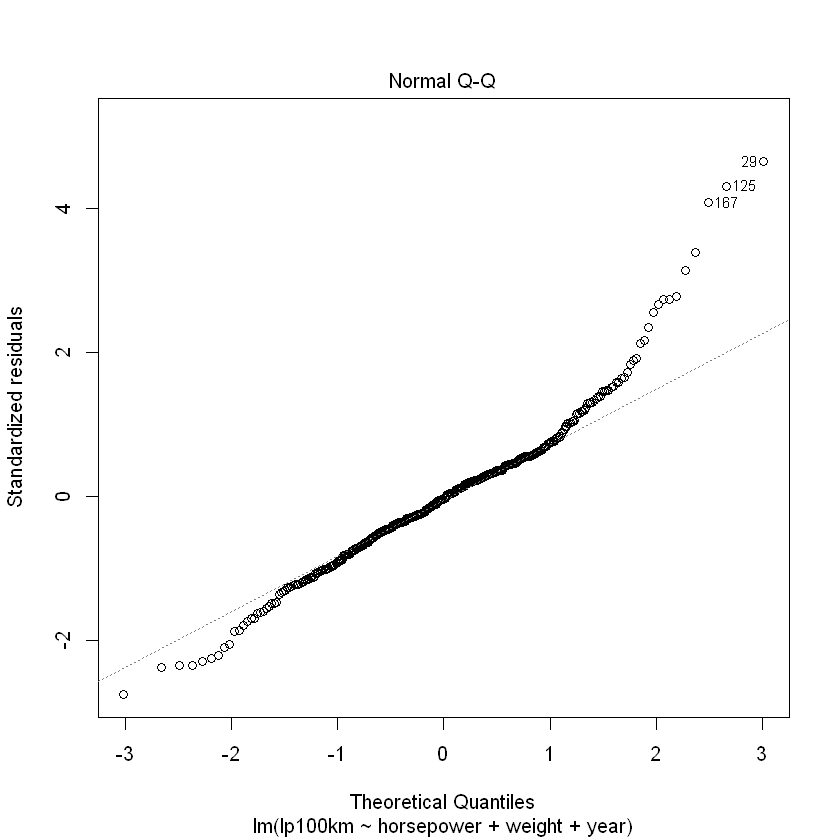

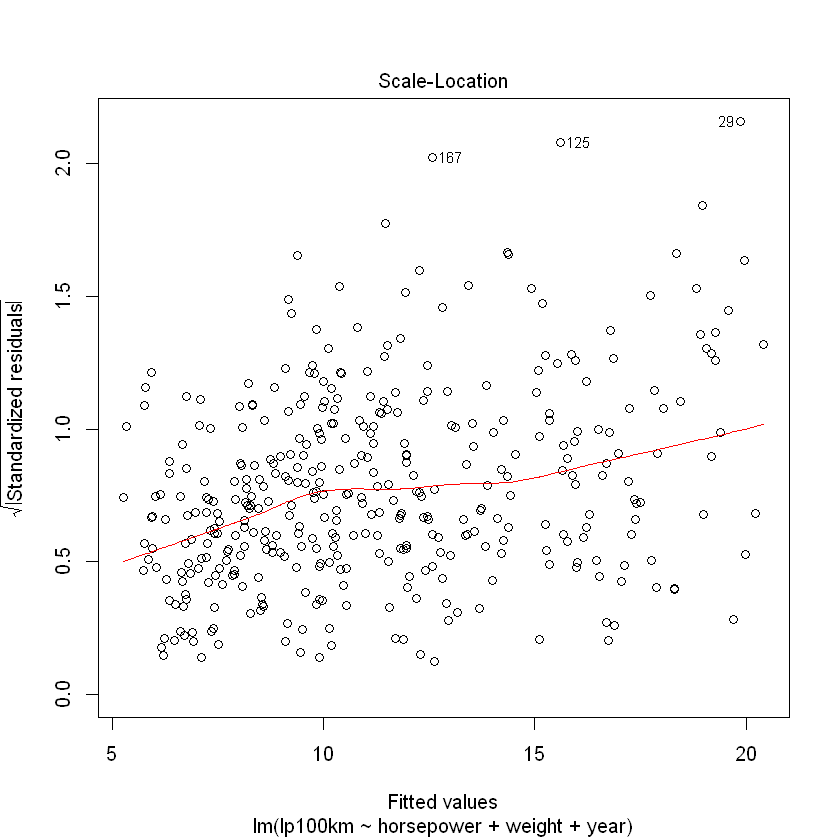

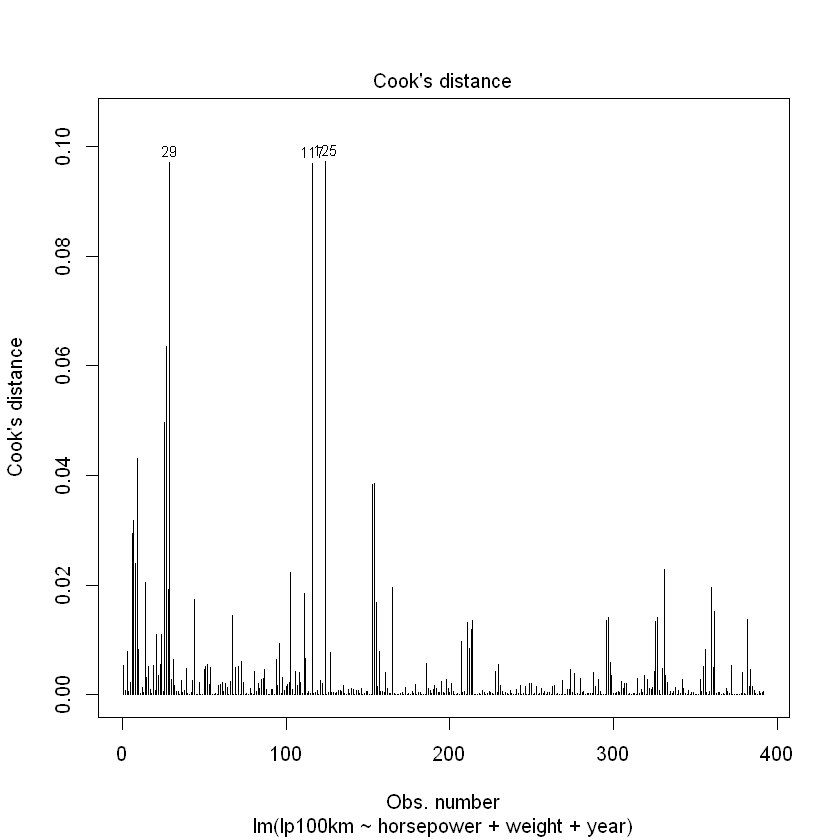

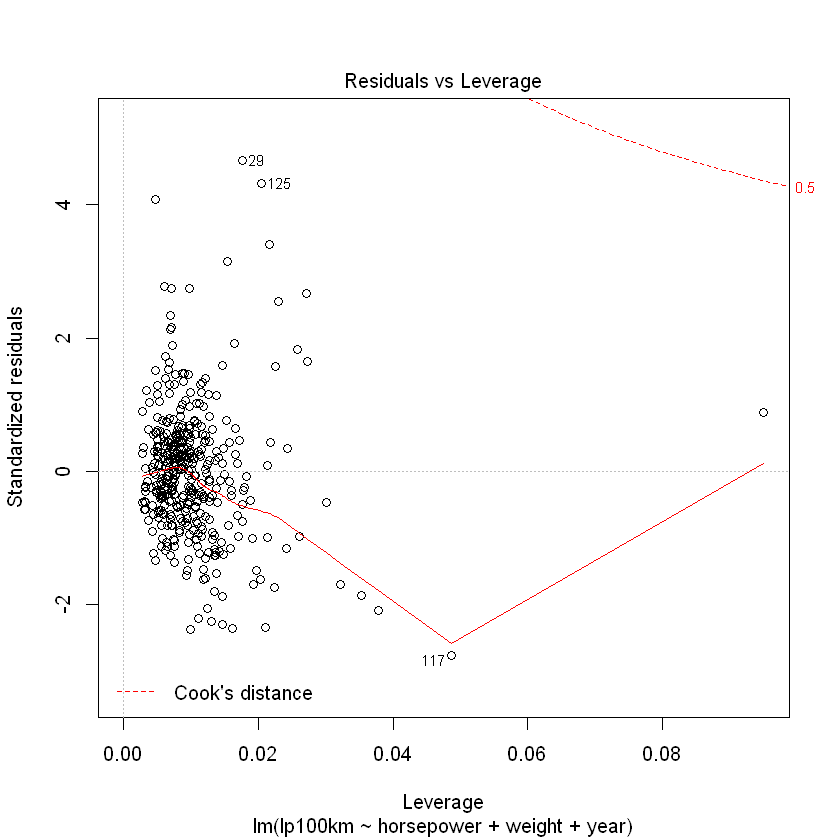

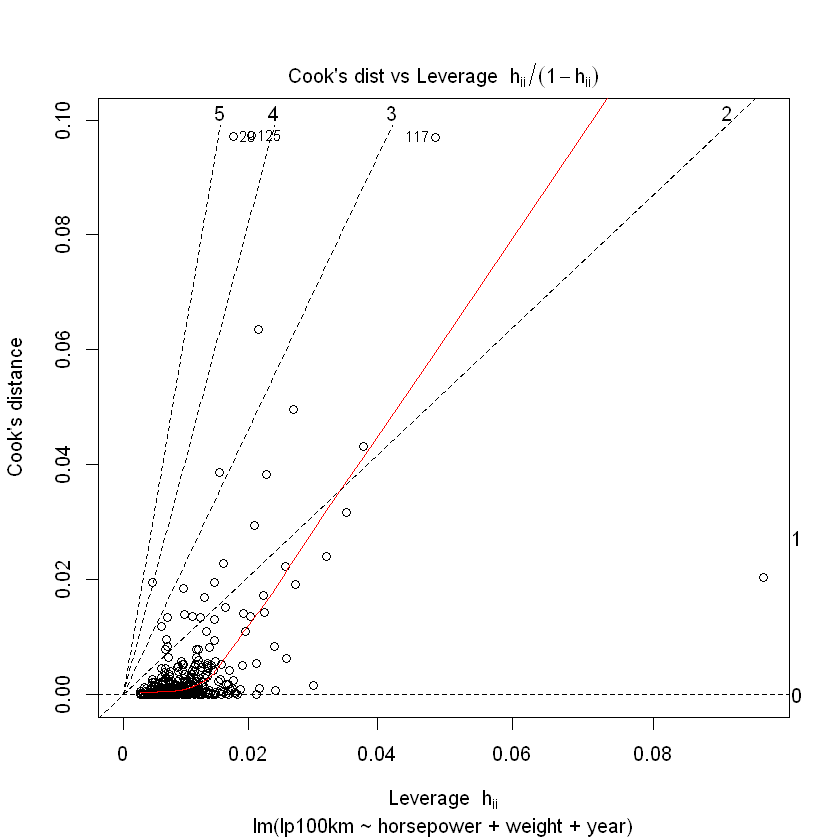

In [108]:
plot(lm.chosen,which=1:6)

Have a look at those observations with large studentized residuals or large cook distance, which are possible outliers.

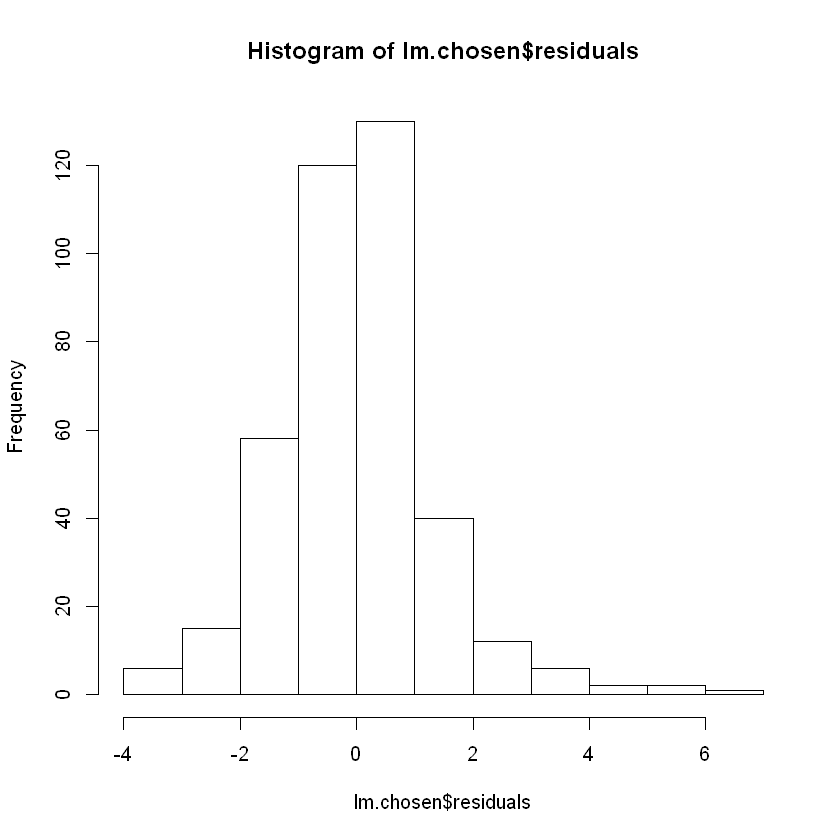

In [119]:
hist(lm.chosen$residuals)

In [120]:
outliers.index<-c(which(abs(rstudent(lm.chosen))>3),116)
cbind(mpg[outliers.index,-1], fitted=lm.chosen$fitted.values[outliers.index])

,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,lp100km,fitted
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<chr>,<dbl>,<dbl>
27,8,307,200,4376,15.0,70,1,chevy c20,23.52146,18.96555
29,8,304,193,4732,18.5,70,1,hi 1200d,26.13495,19.87441
125,8,350,180,3664,11.0,73,1,oldsmobile omega,21.38314,15.59541
156,6,250,72,3158,19.5,75,1,ford maverick,15.68097,11.45363
167,8,302,129,3169,12.0,75,1,ford mustang ii,18.09343,12.57162
117,8,400,230,4278,9.5,73,1,pontiac grand prix,14.70091,18.34536


           Test stat Pr(>|Test stat|)  
horsepower   -0.6325          0.52746  
weight       -0.1752          0.86105  
year         -2.2551          0.02468 *
Tukey test    0.6604          0.50897  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


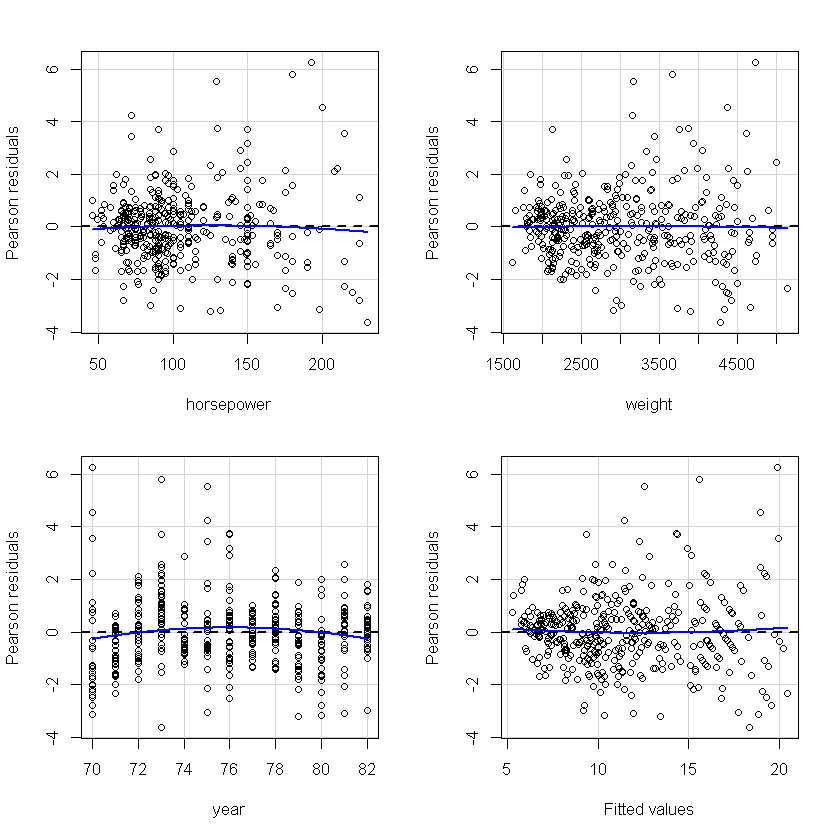

In [17]:
car::residualPlots(lm.chosen)


Call:
lm(formula = lp100km ~ horsepower + weight + year, data = mpg[-outliers.index, 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1412 -0.7552 -0.0144  0.6392  3.8498 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 22.8063504  1.4728703  15.484  < 2e-16 ***
horsepower   0.0176011  0.0034588   5.089 5.67e-07 ***
weight       0.0029274  0.0001467  19.957  < 2e-16 ***
year        -0.2918415  0.0183666 -15.890  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.205 on 382 degrees of freedom
Multiple R-squared:  0.8979,	Adjusted R-squared:  0.8971 
F-statistic:  1119 on 3 and 382 DF,  p-value: < 2.2e-16


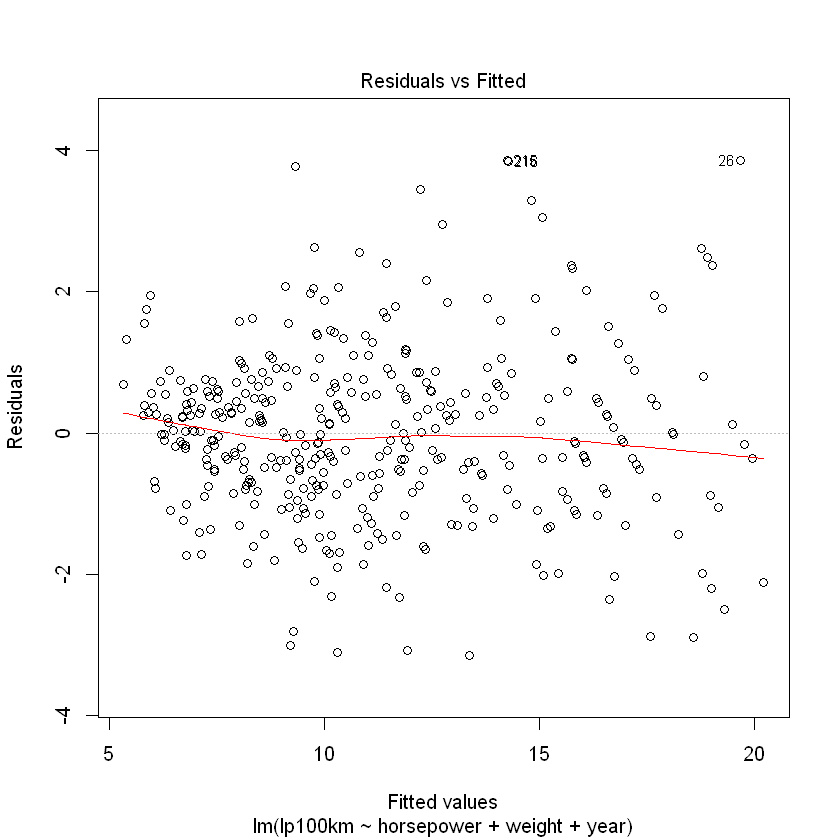

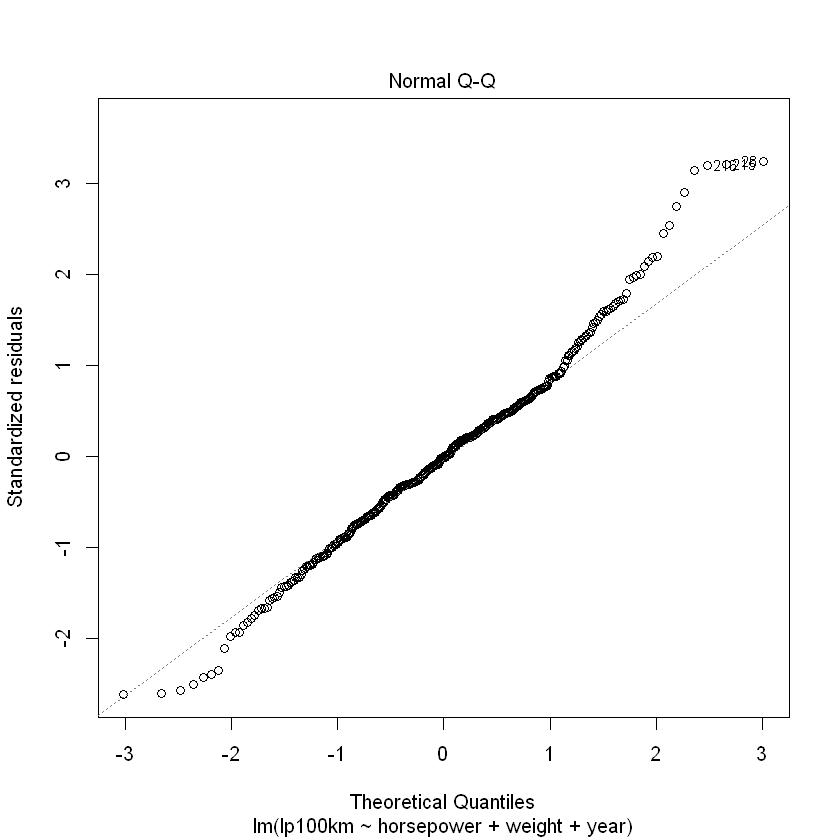

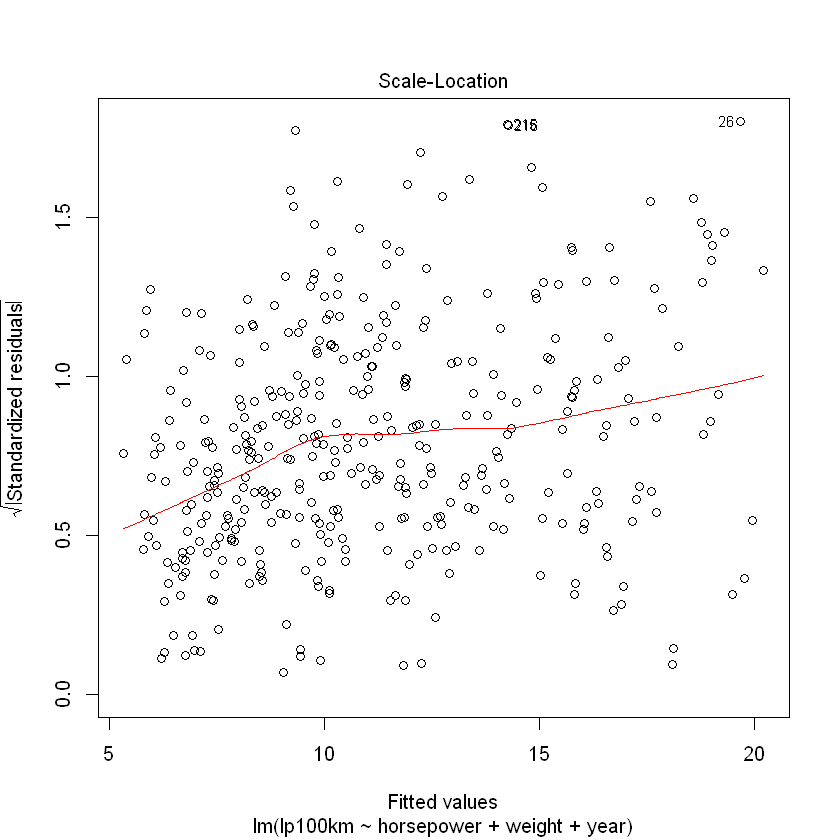

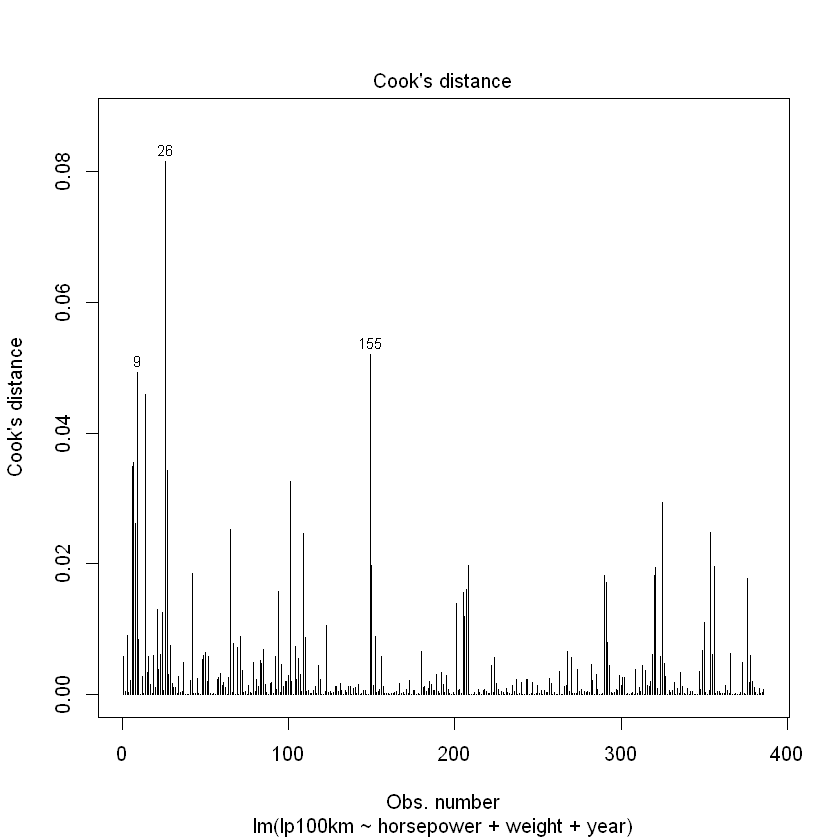

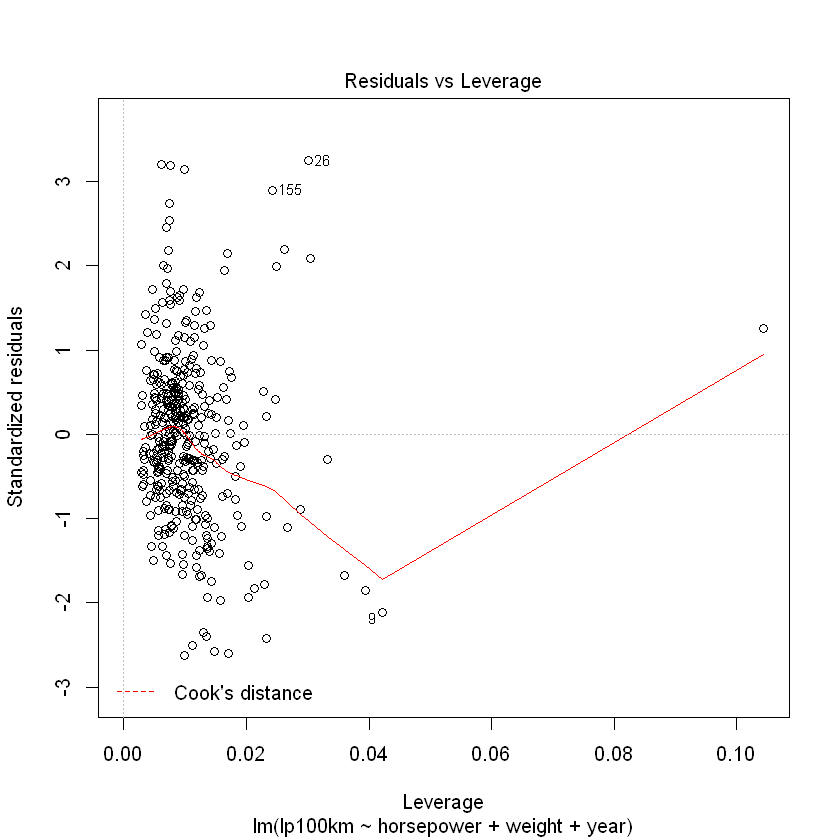

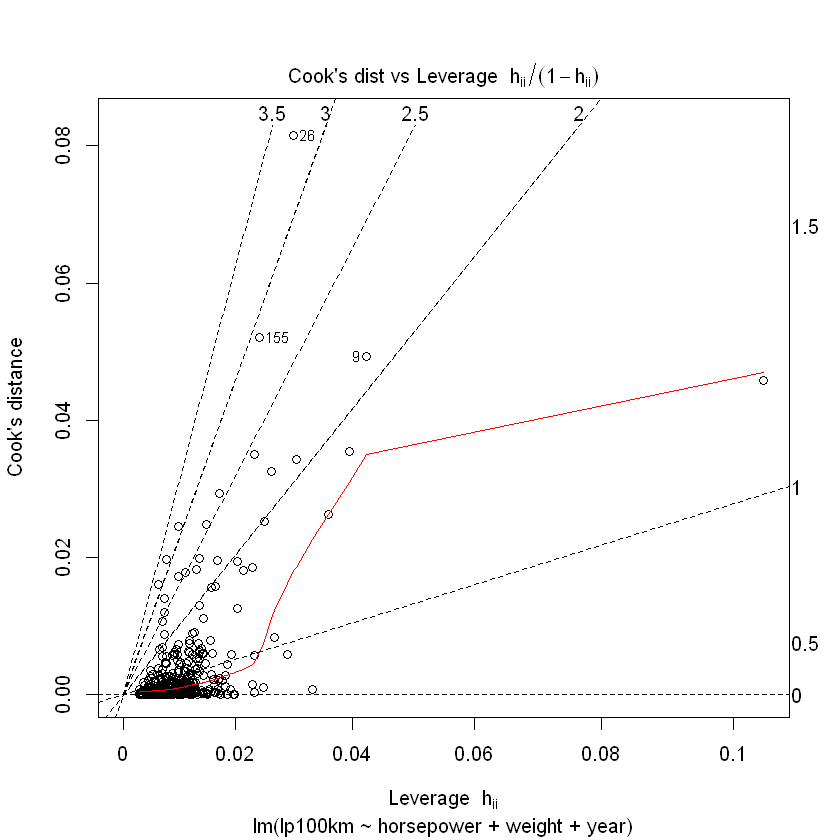

In [114]:
summary(lm.chosen.refit<-lm(lp100km~horsepower+weight+year,data=mpg[-outliers.index,]))
plot(lm.chosen.refit,which=1:6)

# ANOVA and ANCOVA: Is `Origin` predictive of `lp100km`?

In [18]:
summary(lm.origin.anova<-lm(lp100km~origin,data=mpg))
anova(lm.origin.anova)


Call:
lm(formula = lp100km ~ origin, data = mpg)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.8717 -1.9078 -0.3093  1.7981 13.2321 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  12.9028     0.2092  61.683   <2e-16 ***
origin2      -3.9139     0.4488  -8.721   <2e-16 ***
origin3      -4.8396     0.4236 -11.424   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.274 on 389 degrees of freedom
Multiple R-squared:  0.3037,	Adjusted R-squared:  0.3002 
F-statistic: 84.85 on 2 and 389 DF,  p-value: < 2.2e-16


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
origin,2,1819.246,909.62299,84.8516,2.620973e-31
Residuals,389,4170.144,10.72016,NA,NA


It seems that the means of the fuel consumption do differ from different origins. However, after we consider other predictors in the model, origin no longer matters in terms of prediction.

In [19]:
summary(lm.origin.ancova<-lm(lp100km~horsepower+year+weight+origin,data=mpg))
anova(lm.origin.ancova)


Call:
lm(formula = lp100km ~ horsepower + year + weight + origin, data = mpg)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6210 -0.7872 -0.0287  0.6553  6.3275 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 24.4913315  1.6919185  14.475  < 2e-16 ***
horsepower   0.0189366  0.0037703   5.023 7.81e-07 ***
year        -0.3073573  0.0208087 -14.771  < 2e-16 ***
weight       0.0027845  0.0001779  15.653  < 2e-16 ***
origin2     -0.5442584  0.2092972  -2.600  0.00967 ** 
origin3     -0.3223711  0.2115867  -1.524  0.12843    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.347 on 386 degrees of freedom
Multiple R-squared:  0.883,	Adjusted R-squared:  0.8815 
F-statistic: 582.9 on 5 and 386 DF,  p-value: < 2.2e-16


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
horsepower,1,4376.43276,4376.432762,2411.693408,4.162477e-168
year,1,296.65496,296.654959,163.475792,1.863312e-31
weight,1,603.09696,603.096959,332.344866,5.170457e-54
origin,2,12.74137,6.370683,3.510653,3.083499e-02
Residuals,386,700.46343,1.814672,NA,NA


When given the other predictors, origin3 will now be insignificant. However, origin2 remains significant, which indicates that `origin=Europe` itself contributes to a lower fuel consumption. A possible explanation is that European cars focus more on fuel economy (becuase of higher fuel price in Europe), and engines made in Europe, especially German, deployed more advance technology that would save fuel.

# Principle Component Analysis

In [156]:
rownames(mpg)<-paste(mpg$name,mpg$year,round(mpg$lp100km))
PCA<-prcomp(mpg[,2:7],scale. = TRUE)
#PCA<-princomp(mpg[,2:7],cor = TRUE)
summary(PCA)
#PCA$loadings
PCA$rotation

Importance of components:
                          PC1    PC2    PC3     PC4    PC5     PC6
Standard deviation     2.0633 0.9163 0.8203 0.36451 0.2473 0.19073
Proportion of Variance 0.7095 0.1399 0.1121 0.02214 0.0102 0.00606
Cumulative Proportion  0.7095 0.8495 0.9616 0.98374 0.9939 1.00000

,PC1,PC2,PC3,PC4,PC5,PC6
cylinders,-0.4547630,0.18949971,-0.1678793,0.66043399,-0.273785627,0.46686768
displacement,-0.4688572,0.16303989,-0.1315315,0.18824633,-0.001192995,-0.83716918
horsepower,-0.4636587,0.01052532,0.1249778,-0.61826946,-0.613376365,0.10393605
weight,-0.4462521,0.25716695,-0.2700882,-0.35122423,0.685213425,0.26248935
acceleration,0.3246433,0.22125982,-0.8643383,-0.14811227,-0.274496537,-0.03583935
year,0.2320559,0.90681107,0.3447726,-0.02893841,-0.062798531,-0.01394673


In [157]:
PCA.z<-PCA$x

In [158]:
summary(lm.PCR<-lm(mpg$lp100km~1+PCA.z[,1]+PCA.z[,2]+PCA.z[,3]))


Call:
lm(formula = mpg$lp100km ~ 1 + PCA.z[, 1] + PCA.z[, 2] + PCA.z[, 
    3])

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8442 -0.7822 -0.0175  0.6654  7.0728 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.24853    0.07247  155.22  < 2e-16 ***
PCA.z[, 1]  -1.70703    0.03517  -48.54  < 2e-16 ***
PCA.z[, 2]  -0.32786    0.07919   -4.14 4.26e-05 ***
PCA.z[, 3]  -1.07662    0.08846  -12.17  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.435 on 388 degrees of freedom
Multiple R-squared:  0.8666,	Adjusted R-squared:  0.8656 
F-statistic: 840.4 on 3 and 388 DF,  p-value: < 2.2e-16


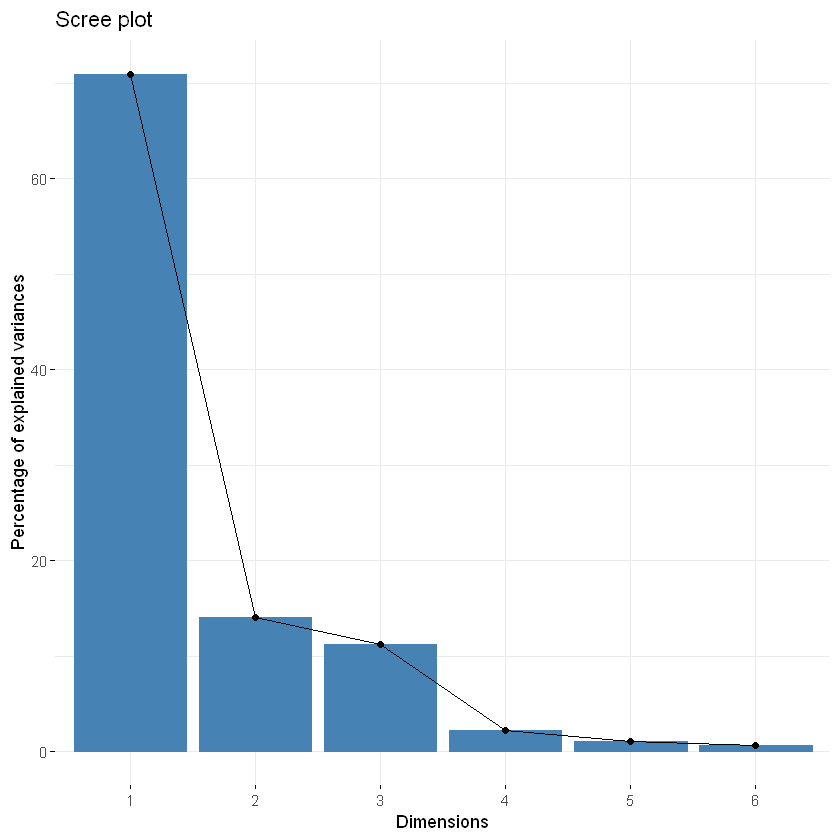

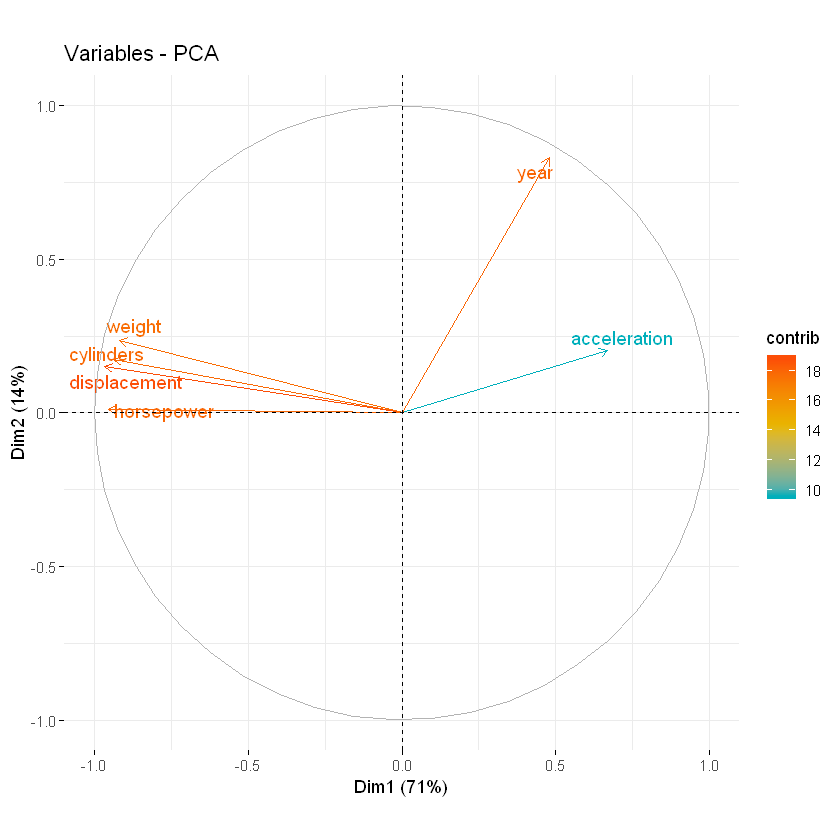

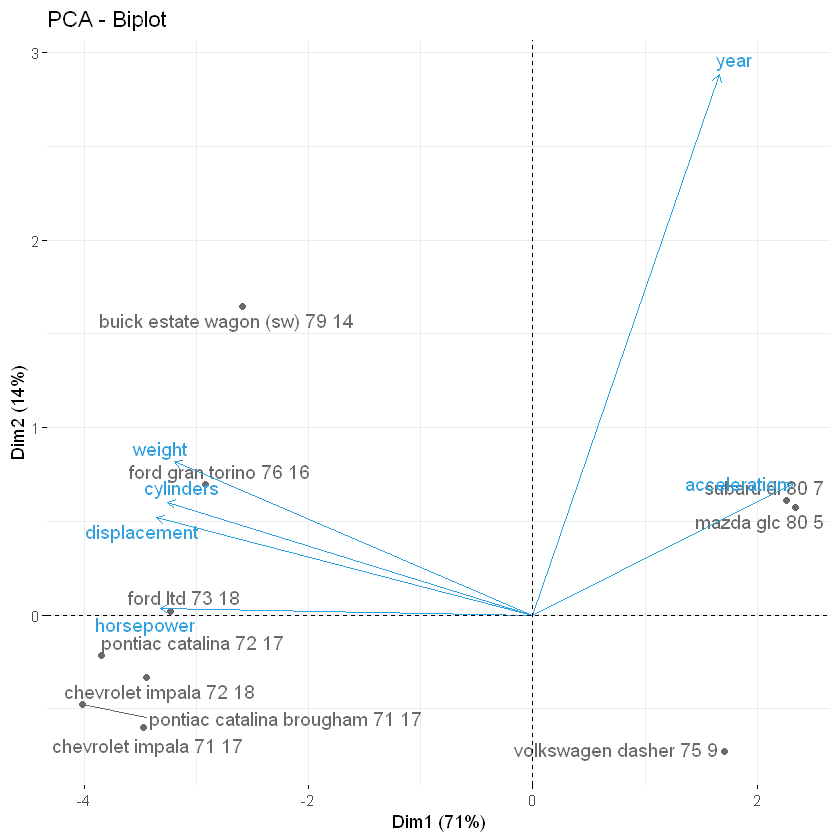

In [160]:
library(factoextra)
fviz_eig(PCA)
fviz_pca_var(PCA,
             col.var = "contrib", # Color by contributions to the PC
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE     # Avoid text overlapping
             )
# fviz_pca_ind(PCA,
#              col.ind = "cos2", # Color by the quality of representation
#              gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              repel = TRUE     # Avoid text overlapping
#              )
#help(fviz_pca_biplot)
fviz_pca_biplot(PCA, repel = TRUE,
                col.var = "#2E9FDF", # Variables color
                col.ind = "#696969",  # Individuals color
                select.ind = list(cos2 = 10)
                )